# Домашнее задание №2. Feed-forward neural network

In [21]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

### Задание

  1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:

   1) изменение слоёв и их количества;
   
   2) изменение метода оптимизации;
   
   3) изменение процесса обучения;
   
   4) *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru


## 0. Загрузка данных<a id='section_0'></a>

In [37]:
# Загрузка датасета CIFAR-10
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

train_dataset = torchvision.datasets.CIFAR10(
    root='data/',  #куда скачиваем файлы, если download=True или где данные(dowload=False)
    train=True,    #датасет для обучения  
    transform=transforms.ToTensor(), # преобразуем данные в формат тензоров
    download=True, # True - надо скачать и положить в root.  False - уже скачано
)

#50 000 изображений
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [38]:
# классы
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

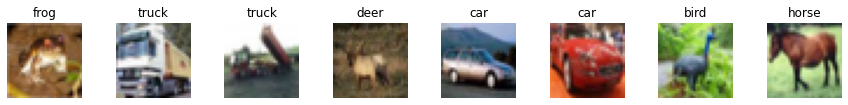

In [39]:
# визуализация тренировочных данных
fig = plt.figure(figsize=(12,96))

for i in range(8):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    
    ax = plt.subplot(1, 8, i+1)
    plt.tight_layout()
    ax.set_title(f'{classes[label]}')
    ax.axis('off')
    image = plt.imshow(image.permute(1, 2, 0).numpy())
        
    if i == 8:
        plt.show()
        break

In [40]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape  #батч размером 64

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [41]:
test_dataset = torchvision.datasets.CIFAR10(root='data/', 
                                            train=False,
                                            download=True, 
                                            transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False)
#10 000 изображений
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

## 1. Базовая модель: построение и обучение нейронной сети FFNN <a id='section_1'></a>

In [42]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1) # преобразуем вход в 3хn (n = 1024 -- что осталось от преобразования в формат 3x...)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x

In [43]:
#инициализация модели
net = Net(3072, 100, 10)  #входной вектор 3*32*32 = 3072, выход 10 классов

In [44]:
#компиляция модели
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [45]:
#обучение модели
net.train()
num_epochs = 5

for epoch in range(num_epochs):
    #текущее значение функции потерь
    running_loss = 0.0
    running_items = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1] # входные данные с лейблами

        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Делаем предсказание
        outputs = net(inputs)
        
        # Рассчитываем лосс-функцию (функцию потерь)
        loss = criterion(outputs, labels)
        
        # Вычисляем градиент
        loss.backward()
        
        # Обновляем веса (делаем шаг оптимайзера)
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.033
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.030
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.029
Epoch [4/5]. Step [1/782]. Loss: 0.028
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.028
Epoch [5/5]. Step [1/782]. Loss: 0.031
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!


In [46]:
# Сохранение весов модели
#PATH_WEIGHTS = 'data/cifar_net_test_version_weights.pth'
#torch.save(net.state_dict(), PATH_WEIGHTS)

# Сохранение модели
#PATH_MODEL = 'data/cifar_net_test_version_model.pth'
#torch.save(net, PATH_MODEL)

# Загрузка сохраненных весов модели
# net = Net(3072, 100, 10)
# net.load_state_dict(torch.load(PATH_WEIGHTS))

# Загрузка модели
#net = torch.load(PATH_MODEL)

### Тестирование модели FFNN

Истинные классы:  cat ship ship plane frog frog car frog


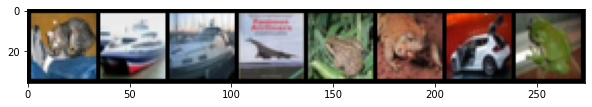

In [47]:
# Изображения из тестового набора
dataiter = iter(test_loader)
images, labels = dataiter.next()

imgs = torchvision.utils.make_grid(images)

plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('Истинные классы: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [48]:
# предсказание модели (верояности принадлежности объекта к классу)
net.eval()
outputs = net(images)

# получение предсказания название класса
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  dog truck ship ship deer frog dog deer


In [49]:
# результаты модели
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'truck' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.25


## 1.1. Изменение базовой модели <a id='section_1.1'></a>

### 1.1.1. Увеличение числа эпох <a id='section_1.1.1'></a>

In [ ]:
# функция процесса обучения и оценки модели для каждой эпохи.
# для анализа динамики при увеличении числа эпох

def train_pred_model_epoch_finding(max_num_epochs, train_loader, test_loader, model, criterion, optimizer):
    
    current_accuracy = 0
    optimal_epochs = 0
    loss_steps = 0

    statistic = np.array([[0, 0, 0]])

    #обучение модели
    model.train()
    for epoch in range(max_num_epochs):
    #текущее значение функции потерь
        running_loss = 0.0
        running_items = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1] # входные данные с лейблами

            # Обнуляем градиент
            optimizer.zero_grad()

            # Делаем предсказание
            outputs = model(inputs)

            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs, labels)

            # Вычисляем градиент
            loss.backward()

            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            # if i % 300 == 0:    # печатаем каждые 300 mini-batches
            #     print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            #           f'Step [{i + 1}/{len(train_loader)}]. ' \
            #           f'Loss: {running_loss / running_items:.3f}')
            #     running_loss, running_items = 0.0, 0.0

        #оценка модели
        model.eval()
        # Изображения из тестового набора
        dataiter = iter(test_loader)
        images, labels = dataiter.next()

        # предсказание модели (верояности принадлежности объекта к классу)
        outputs = model(images)
        # imgs = torchvision.utils.make_grid(images)

        # plt.figure(figsize=(10, 5))
        # plt.imshow(imgs.permute(1, 2, 0).numpy())
        # print('Test classes: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

        # получение предсказания название класса
        _, predicted = torch.max(outputs, 1)

        gt = np.array([classes[labels[j]] for j in range(len(labels))])
        pred = np.array([classes[predicted[j]] for j in range(len(labels))])
        accuracy = (gt == pred).sum() / len(gt)

        if (i+1) % 10 == 0:    # печатаем каждые 10 эпох, чтобы следить за процессом
            print(f'Epoch [{epoch + 1}/{max_num_epochs}]. ' \
                  f'Loss: {running_loss / running_items:.3f} ' \
                  f'Accuracy is {accuracy:.3f}' )

        statistic = np.append(statistic, [[epoch+1, running_loss / running_items, accuracy]], axis = 0) 

        if current_accuracy <= accuracy:
            current_accuracy = accuracy
            optimal_epochs = epoch
            loss_steps = 0
        elif loss_steps < 9:
            loss_steps += 1  
        else: 
          break
    
    print(f'Training is finished!. Numbers of epoch: {optimal_epochs+1}')
    statistic = np.delete(statistic, 0, 0)
    return statistic
    


Training is finished!. Numbers of epoch: 9


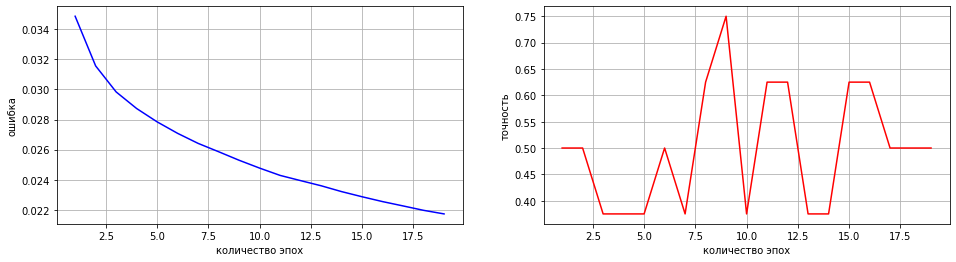

In [ ]:
max_num_epochs = 50
train_loader = train_loader
test_loader = test_loader
model = Net(3072, 100, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

statistic = train_pred_model_epoch_finding(max_num_epochs, train_loader, test_loader, model, criterion, optimizer)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество эпох')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** в общем, увеличение числа эпох способствует улучшению базовой метрики. Но стабильности по метрике Accuracy на данном примере не наблюдается. Среднего ожидаемого значения Accuracy = 0.5 удается достич уже на первых 5 эпохах. А loss после 10-й эпохи уменьшается незначительно. Поэтому, для нашего случая можно считать 10 эпох - оптимальным значением.

### 1.1.2. Увеличение числа нейронов<a id='section_1.1.2'></a>

In [50]:
# функция процесса обучения и оценки модели для каждой эпохи.
# для анализа динамики при увеличении числа эпох

def train_pred_model(num_epochs, train_loader, test_loader, model, criterion, optimizer):
    
    #обучение модели
    model.train()
    for epoch in range(num_epochs):
    #текущее значение функции потерь
        running_loss = 0.0
        running_items = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1] # входные данные с лейблами

            # Обнуляем градиент
            optimizer.zero_grad()

            # Делаем предсказание
            outputs = model(inputs)

            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs, labels)

            # Вычисляем градиент
            loss.backward()

            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)

        #оценка модели
        model.eval()
        # Изображения из тестового набора
        dataiter = iter(test_loader)
        images, labels = dataiter.next()

        # предсказание модели (верояности принадлежности объекта к классу)
        outputs = model(images)

        # получение предсказания название класса
        _, predicted = torch.max(outputs, 1)

        gt = np.array([classes[labels[j]] for j in range(len(labels))])
        pred = np.array([classes[predicted[j]] for j in range(len(labels))])
        accuracy = (gt == pred).sum() / len(gt)
        loss = running_loss / running_items

   
    # print(f'Training is finished!. Numbers of epoch: {optimal_epochs+1}')
    return loss, accuracy


Neuron count: 150. Loss: 0.025. Accuracy is 0.625
Neuron count: 200. Loss: 0.025. Accuracy is 0.500
Neuron count: 250. Loss: 0.025. Accuracy is 0.750
Neuron count: 300. Loss: 0.024. Accuracy is 0.500
Neuron count: 350. Loss: 0.024. Accuracy is 0.750
Neuron count: 400. Loss: 0.024. Accuracy is 0.250
Neuron count: 450. Loss: 0.024. Accuracy is 0.125
Neuron count: 500. Loss: 0.024. Accuracy is 0.625


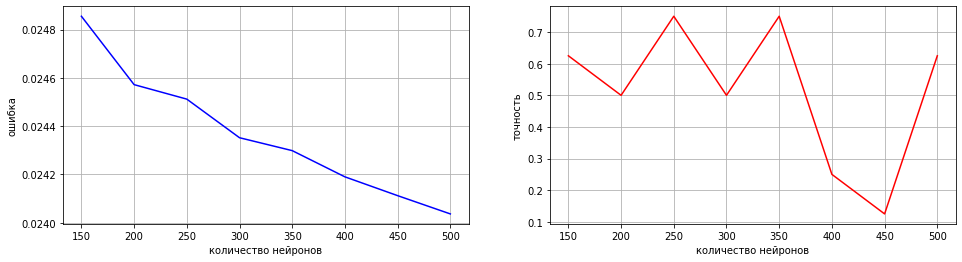

In [ ]:
num_epochs = 10
train_loader = train_loader
test_loader = test_loader
criterion = nn.CrossEntropyLoss()

current_accuracy = 0

statistic = np.array([[0, 0, 0]])


for nenu in range(150, 550, 50):

    model = Net(3072, nenu, 10)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
    loss, accuracy = train_pred_model(num_epochs, train_loader, test_loader, model, criterion, optimizer)

    print(f'Neuron count: {nenu}. ' \
          f'Loss: {loss:.3f}. ' \
          f'Accuracy is {accuracy:.3f}' )
 
    if current_accuracy <= accuracy:
        current_accuracy = accuracy
    
    statistic = np.append(statistic, [[nenu, loss, accuracy]], axis = 0) 

statistic = np.delete(statistic, 0, 0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество нейронов')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество нейронов')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** увеличение числа нейронов до определенного предела способствует улучшению базовой метрики. Судя по статистике оптимальным значением по числу нейронов в скрытом слое является 350.

### 1.1.3. Увеличение количества слоев<a id='section_1.1.3'></a>

In [ ]:
class Net_layers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_layers_count):

        super().__init__()
        self.hidden_layers_count = hidden_layers_count

        mc = pow(2, self.hidden_layers_count-1)
        # self.fc1 = nn.Linear(input_dim, mc * hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        for i in range(self.hidden_layers_count-1):
            varname = 'fc'+str(i+2)
            # print(mc, varname)
            # l = nn.Linear(mc * hidden_dim, int(mc / 2) * hidden_dim)
            l = nn.Linear(hidden_dim, hidden_dim)
            setattr(self, varname, l)
            mc = int(mc / 2)            
            # print(len(list(self.parameters())))

        varname = 'fc'+str(self.hidden_layers_count+1)
        # print(mc, varname)
        # l = nn.Linear(mc * hidden_dim, output_dim)
        l = nn.Linear(hidden_dim, output_dim)
        setattr(self, varname, l)
        # print(self.__dict__)
        # print(len(list(self.parameters())))
      
        
    def forward(self, x):

        x = x.view(x.shape[0], -1)
        # print(self.fc1)
        x = self.fc1(x)
        
        for i in range(self.hidden_layers_count):
            x = F.leaky_relu(x)
            varname = 'fc'+str(i+2)
            # print(getattr(self, varname))
            x = getattr(self, varname)(x)

        return x
    
    def predict(self, x):

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        
        for i in range(self.hidden_layers_count):
            x = F.leaky_relu(x)
            varname = 'fc'+str(i+2)
            x = getattr(self, varname)(x)

        x = F.softmax(x)

        return x


Lyers count: 3. Loss: 0.025. Accuracy is 0.375
Lyers count: 6. Loss: 0.031. Accuracy is 0.375
Lyers count: 9. Loss: 0.036. Accuracy is 0.250
Lyers count: 12. Loss: 0.036. Accuracy is 0.125


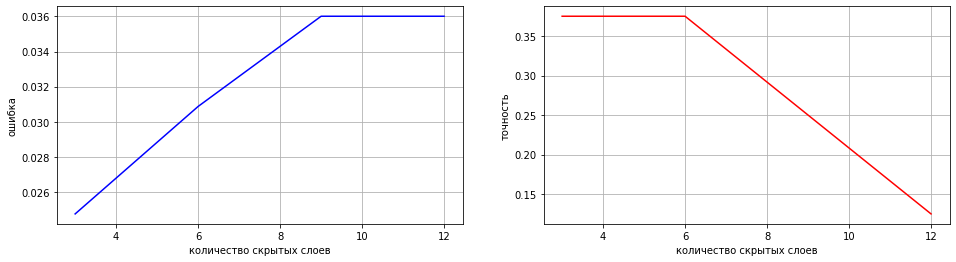

In [ ]:
num_epochs = 10
train_loader = train_loader
test_loader = test_loader
criterion = nn.CrossEntropyLoss()

current_accuracy = 0

statistic = np.array([[0, 0, 0]])


for lyers_count in range(3, 15, 3):

    model = None
    model = Net_layers(3072, 350, 10, lyers_count) #Net(3072, nenu, 10)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
    loss, accuracy = train_pred_model(num_epochs, train_loader, test_loader, model, criterion, optimizer)

    print(f'Lyers count: {lyers_count}. ' \
          f'Loss: {loss:.3f}. ' \
          f'Accuracy is {accuracy:.3f}' )
 
    if current_accuracy <= accuracy:
        current_accuracy = accuracy
    
    statistic = np.append(statistic, [[lyers_count, loss, accuracy]], axis = 0) 

statistic = np.delete(statistic, 0, 0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('количество скрытых слоев')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('количество скрытых слоев')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** увеличение количества слоев не приводит к улучшению базаовой метрики. Даже, скореее, ухудшает. Что соответствует истории из предыдущих крсов.

### 1.1.4. Изменение метода оптимизации<a id='section_1.1.4'></a>

Optimize method number: 1. Loss: 0.033. Accuracy is 0.375
Optimize method number: 2. Loss: 0.021. Accuracy is 0.875
Optimize method number: 3. Loss: 0.019. Accuracy is 0.875
Optimize method number: 4. Loss: 0.033. Accuracy is 0.500
Optimize method number: 5. Loss: 0.022. Accuracy is 0.500


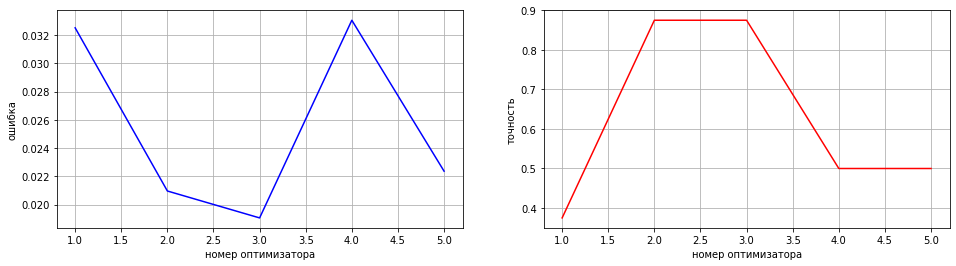

In [18]:
num_epochs = 10
train_loader = train_loader
test_loader = test_loader
criterion = nn.CrossEntropyLoss()

current_accuracy = 0

statistic = np.array([[0, 0, 0]])

# opt_list = [optim.SGD(model.parameters(), lr=0.01, momentum=0.0),
#             optim.Adam(model.parameters(), lr=0.001),
#             optim.Adamax(model.parameters(), lr=0.001),
#             optim.Adadelta(model.parameters(), lr=0.001),
#             optim.RMSprop(model.parameters(), lr=0.001)]

opt_list = ['SGD',
            'Adam',
            'Adamax',
            'Adadelta',
            'RMSprop']

cnt = 1
for optimizer_name in opt_list:

    model = None
    model = Net(3072, 350, 10)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=0.001)
    loss, accuracy = train_pred_model(num_epochs, train_loader, test_loader, model, criterion, optimizer)

    print(f'Optimize method number: {cnt}. ' \
          f'Loss: {loss:.3f}. ' \
          f'Accuracy is {accuracy:.3f}' )
    
    statistic = np.append(statistic, [[cnt, loss, accuracy]], axis = 0)

    cnt += 1 

statistic = np.delete(statistic, 0, 0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('номер оптимизатора')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('номер оптимизатора')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** изменение метода оптимизации приводит к улучшению результата. AdamMax показал лучший результат. Поэтому будем использовать его в дальнейшем.

### 1.1.5. Увеличение батча в train_loader<a id='section_1.1.5'></a>

In [ ]:
train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=256, 
                                           shuffle=True)

Иatch size: 32. Loss: 0.038. Accuracy is 0.750
Иatch size: 64. Loss: 0.019. Accuracy is 0.625
Иatch size: 128. Loss: 0.010. Accuracy is 0.625
Иatch size: 256. Loss: 0.005. Accuracy is 0.500
Иatch size: 512. Loss: 0.003. Accuracy is 0.625


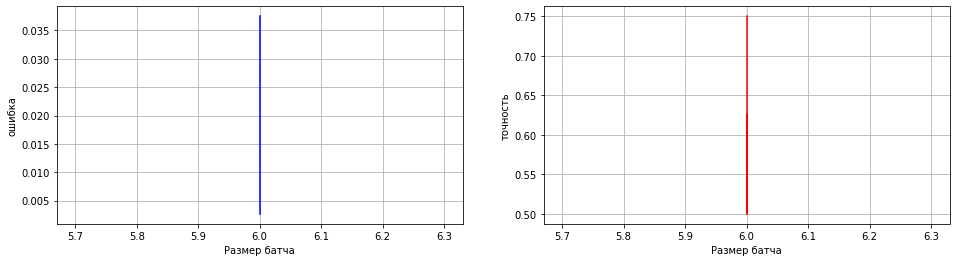

In [19]:
num_epochs = 10
# train_loader = train_loader_1
test_loader = test_loader
criterion = nn.CrossEntropyLoss()

batch_size_list = [32, 64, 128, 256, 512]
statistic = np.array([[0, 0, 0]])

for batch_size in batch_size_list:

    train_loader_1 = None
    train_loader_1 = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

    model = None
    model = Net(3072, 350, 10)
    optimizer = optim.Adamax(model.parameters(), lr=0.001)

    loss, accuracy = train_pred_model(num_epochs, train_loader_1, test_loader, model, criterion, optimizer)

    print(f'Batch size: {batch_size}. ' \
          f'Loss: {loss:.3f}. ' \
          f'Accuracy is {accuracy:.3f}' )
    
    statistic = np.append(statistic, [[batch_size, loss, accuracy]], axis = 0)

 
statistic = np.delete(statistic, 0, 0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('Размер батча')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('Размер батча')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** графики вывелись неудачно. Наверное я напутал что-то в переменных. Переделывать не буду, т.к. это занимает много времени. А результат виден в таблице. Чем больше размер батча, тем лучше loss. А вот на Accuracy изменение этого показателя не сильно влияет. Выберем 128 для дальнейших экспериментов.

In [35]:
train_loader = None
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=128, 
                                           shuffle=True)


### 1.1.6. Изменение функции активации<a id='section_1.1.6'></a>

In [36]:
class Net_act_func(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, act_func_name):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.act_func_name = act_func_name

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc2(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc3(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc2(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc3(x)
        x = getattr(F, self.act_func_name)(x) 
        x = self.fc4(x)
        x = F.softmax(x)
        return x

Activation function: relu. Loss: 0.003. Accuracy is 0.375
Activation function: leaky_relu. Loss: 0.003. Accuracy is 0.500
Activation function: elu. Loss: 0.003. Accuracy is 0.375


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Activation function: tanh. Loss: 0.003. Accuracy is 0.500


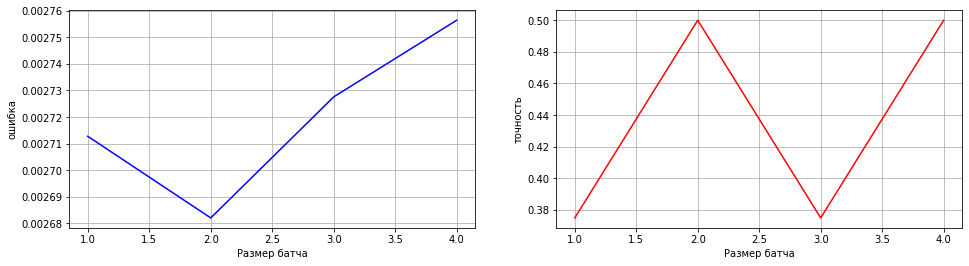

In [51]:
num_epochs = 10
train_loader = train_loader
test_loader = test_loader
criterion = nn.CrossEntropyLoss()

act_func_list = ['relu', 'leaky_relu', 'elu', 'tanh']
statistic = np.array([[0, 0, 0]])

cnt = 0
for act_func in act_func_list:

    cnt += 1

    model = None
    model = Net_act_func(3072, 350, 10, act_func)
    optimizer = optim.Adamax(model.parameters(), lr=0.001)

    loss, accuracy = train_pred_model(num_epochs, train_loader_1, test_loader, model, criterion, optimizer)

    print(f'Activation function: {act_func}. ' \
          f'Loss: {loss:.3f}. ' \
          f'Accuracy is {accuracy:.3f}' )
    
    statistic = np.append(statistic, [[cnt, loss, accuracy]], axis = 0)

 
statistic = np.delete(statistic, 0, 0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.grid('On')
plt.xlabel('Размер батча')
plt.ylabel('ошибка')
plt.plot(statistic[:,0], statistic[:,1],'-b')

plt.subplot(1, 2, 2)
plt.grid('On')
plt.xlabel('Размер батча')
plt.ylabel('точность')
plt.plot(statistic[:,0], statistic[:,2],'-r')

plt.show()

**Вывод:** изменение функции активации не способствует улучшению метрики (но увеличивает базовую метрику). Самый лучший loss у leaky_relu

### 1.1.7*. Преобразование данных<a id='section_1.1.7'></a>

In [52]:
trans_actions = transforms.Compose([transforms.Resize(44), #масштабирование (растягиваем до 44)
                                    transforms.RandomCrop(32, padding=4), #обрезание изображения размером (32,32) в случайном месте, заполнение по границам 4
                                    transforms.ToTensor()])#преобразование PIL изображения (h,w,c) в тензор (c,h,w) со значениями от 0 до 1

In [53]:
train_dataset_2 = torchvision.datasets.CIFAR10(root='data/',  
                                               train=True,    
                                               transform=trans_actions, 
                                               download=True)

train_loader_2 = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_dataset_2 = torchvision.datasets.CIFAR10(root='data/', 
                                            train=False,
                                            download=True, 
                                            transform=trans_actions)

test_loader_2 = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
num_epochs = 10
train_loader = train_loader_2
test_loader = test_loader_2
model = Net(3072, 350, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

train_pred_model(num_epochs, train_loader, test_loader, model, criterion, optimizer)

(0.019151003614664076, 0.75)

**Вывод:** трансформация данных не влечет улучшение метрики (но увеличивает базовую метрику).

## 1.2. Вывод<a id='section_1.2'></a>

Улучшению базовой модели способствует:

1) увеличение числа эпох, 

2) выбор оптимизатора,

3) изменение функции активации,

5) трансформация и аугментация данных.

Максимальное значение Accuracy 0,875 удавалось получить при всех этих способах измения параметров модели.

А увеличение числа нейронов в скрытых слоях и количества самих слоев приводит к переобучению. Что значительно снижает качество модели.